# 7.2 階層ベイズモデル(hierarchical Bayesian model)

In [1]:
# パッケージの読み込み
using Distributions, PyPlot, ForwardDiff, LinearAlgebra

In [2]:
# n次元単位行列
eye(n) = Diagonal{Float64}(I, n)

# パラメータ抽出用の関数
unzip(a) = map(x -> getfield.(a, x), fieldnames(eltype(a)))

unzip (generic function with 1 method)

In [3]:
function set_options(ax, xlabel, ylabel, title;
                     grid=true, gridy=false, legend=false)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    if grid
        if gridy
            ax.grid(axis="y")
        else
            ax.grid()
        end
    end
    legend && ax.legend()
    return
end

set_options (generic function with 1 method)

In [4]:
# ハミルトニアンモンテカルロ法
function HMC(log_p_tilde, μ₀; maxiter::Int=100_000, L::Int=100, ϵ::Float64=1e-1)
    # leapfrogによる値の更新
    function leapflog(grad, p_in, μ_in, L, ϵ)
        μ = μ_in
        p = p_in + 0.5 * ϵ * grad(μ)
        for l in 1:L-1
            μ += ϵ * p
            p += ϵ * grad(μ)
        end
        μ += ϵ * p
        p += 0.5 * ϵ * grad(μ)
        p, μ
    end
    
    # 非正規化対数事後分布の勾配関数を計算
    grad(μ) = ForwardDiff.gradient(log_p_tilde, μ)
    
    # サンプルを格納する配列
    D = length(μ₀)
    μ_samples = Array{typeof(μ₀[1]), 2}(undef, D, maxiter)
    
    # 初期サンプル
    μ_samples[:, 1] = μ₀
    
    # 受容されたサンプルの数
    num_accepted = 1
    
    for i in 2:maxiter
        # 運動量 p の生成
        p_in = randn(size(μ₀))
        
        # リープフロッグ法
        p_out, μ_out = leapflog(grad, p_in, μ_samples[:, i-1], L, ϵ)
                
        # 比率 r (の対数)を計算
        μ_in = μ_samples[:, i-1]
        log_r = (log_p_tilde(μ_out) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_out))) -
                (log_p_tilde(μ_in) +
                 logpdf(MvNormal(zeros(D), eye(D)), vec(p_in)))
        
        # 確率 r でサンプルを受容する
        is_accepted = min(1, exp(log_r)) > rand()
        new_samples = is_accepted ? μ_out : μ_in
        
        # 新しいサンプルを格納
        μ_samples[:, i] = new_samples
        
        # 受容された場合、合計をプラスする
        num_accepted += is_accepted
    end
    
    μ_samples, num_accepted
end

HMC (generic function with 1 method)

In [5]:
# ラッパー関数の定義
function inference_wrapper_HMC(log_joint, paras, w_init; 
                               maxiter::Int=100000, L::Int=100, ϵ::Float64=1e-1)
    ulp(w) = log_joint(w, paras...)
    HMC(ulp, w_init, maxiter=maxiter, L=L, ϵ=ϵ)
end

inference_wrapper_HMC (generic function with 1 method)

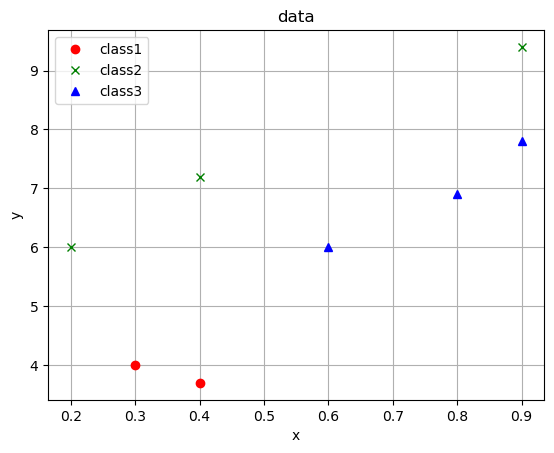

In [6]:
# 学習データ
X_obs = []
Y_obs = []

push!(X_obs, [0.3, 0.4])
push!(Y_obs, [4.0, 3.7])

push!(X_obs, [0.2, 0.4, 0.9])
push!(Y_obs, [6.0, 7.2, 9.4])

push!(X_obs, [0.6, 0.8, 0.9])
push!(Y_obs, [6.0, 6.9, 7.8])

# 散布図で可視化
fig, ax = subplots()
ax.plot(X_obs[1], Y_obs[1], "or", label="class1")
ax.plot(X_obs[2], Y_obs[2], "xg", label="class2")
ax.plot(X_obs[3], Y_obs[3], "^b", label="class3")
set_options(ax, "x", "y", "data", legend=true)

In [7]:
function linear_fit(Y, X)
    N = length(Y)
    w₁ = sum((Y .- mean(Y)) .* X) / sum((X .- mean(X)) .* X)
    w₂ = mean(Y) - w₁ * mean(X)
    w₁, w₂
end

linear_fit (generic function with 1 method)

In [8]:
# まとめて回帰
w₁, w₂ = linear_fit(vcat(Y_obs...), vcat(X_obs...))

(4.960556844547572, 3.58468677494199)

In [9]:
# 個別に回帰
w₁s = []
w₂s = []
for i in 1:3
    w₁_tmp, w₂_tmp = linear_fit(Y_obs[i], X_obs[i])
    push!(w₁s, w₁_tmp)
    push!(w₂s, w₂_tmp)
end

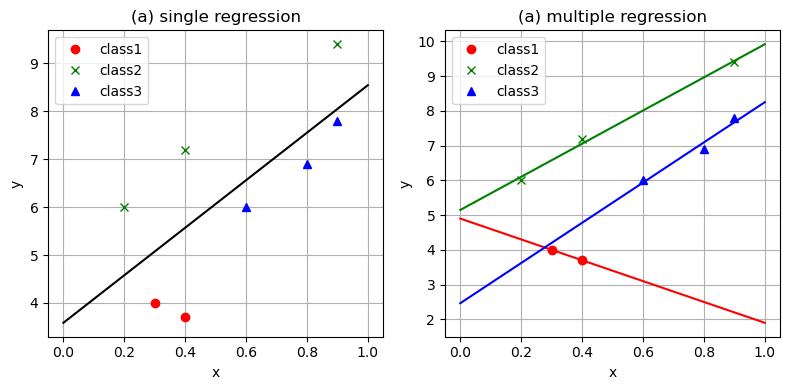

In [10]:
# 関数を可視化する範囲
xs = range(0, 1, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

# 単一の回帰
axes[1].plot(xs, w₁ .* xs .+ w₂, "-k")

# 個別の回帰
axes[2].plot(xs, w₁s[1] .* xs .+ w₂s[1], "-r")
axes[2].plot(xs, w₁s[2] .* xs .+ w₂s[2], "-g")
axes[2].plot(xs, w₁s[3] .* xs .+ w₂s[3], "-b")

# データの回帰
for ax in axes
    ax.plot(X_obs[1], Y_obs[1], "or", label="class1")
    ax.plot(X_obs[2], Y_obs[2], "xg", label="class2")
    ax.plot(X_obs[3], Y_obs[3], "^b", label="class3")
end

set_options(axes[1], "x", "y", "(a) single regression", legend=true)
set_options(axes[2], "x", "y", "(a) multiple regression", legend=true)

tight_layout()

In [11]:
# 対数同時分布の設計
@views hyper_prior(w) = logpdf(Normal(0, 10.0), w[1]) +
                        logpdf(Normal(0, 10.0), w[2])
@views prior(w) = sum(logpdf.(Normal.(w[1], 1.0), w[3:5])) +
                  sum(logpdf.(Normal.(w[2], 1.0), w[6:8]))
@views log_likelihood(Y, X, w) = 
            sum([sum(logpdf.(Normal.(Y[i], 1.0), w[2+i] .* X[i] .+ w[2+i+3])) for i in 1:3])
log_joint(w, X, Y) = hyper_prior(w) + prior(w) + log_likelihood(Y_obs, X_obs, w)
paras = (Y_obs, X_obs)
ulp(w) = log_joint(w, paras...)
# ulp(w) = hyper_prior(w) + prior(w) + log_likelihood(w, paras...)

ulp (generic function with 1 method)

In [12]:
# 初期値
w_init = randn(8)

# サンプリング
maxiter = 1000
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter, L=100, ϵ=0.01)

([-0.22168681377070165 1.5159466607639769 … 5.87939619111148 6.615062418858855; -0.44331839877508455 1.45051430120297 … 3.248252394376234 2.718956908968131; … ; -0.40654944585698866 7.2572221690944625 … 4.4249623583554225 4.131009653154912; -0.7655494718921019 6.131318134033011 … 1.7266087988228827 2.6142861037845724], 1000)

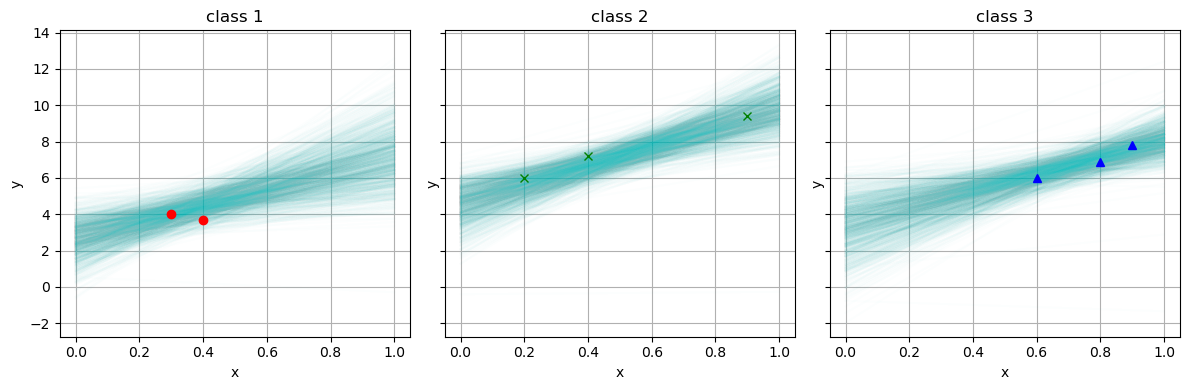

In [13]:
# 予測分布の可視化
fig, axes = subplots(1, 3, sharey=true, figsize=(12, 4))

for i in 1:3
    for j in 1:size(param_posterior_HMC, 2)
        w₁, w₂ = param_posterior_HMC[[2+i, 2+i+3], j]
        axes[i].plot(xs, w₁ .* xs .+ w₂, "c-", alpha=0.01)
    end
    set_options(axes[i], "x", "y", "class $(i)")
end
axes[1].plot(X_obs[1], Y_obs[1], "or")
axes[2].plot(X_obs[2], Y_obs[2], "xg")
axes[3].plot(X_obs[3], Y_obs[3], "^b")

tight_layout()

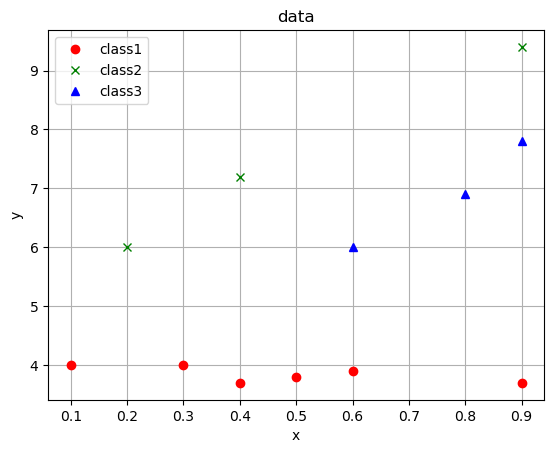

In [14]:
# 学習データ
X_obs = []
Y_obs = []

push!(X_obs, [0.1, 0.3, 0.4, 0.5, 0.6, 0.9])
push!(Y_obs, [4.0, 4.0, 3.7, 3.8, 3.9, 3.7])

push!(X_obs, [0.2, 0.4, 0.9])
push!(Y_obs, [6.0, 7.2, 9.4])

push!(X_obs, [0.6, 0.8, 0.9])
push!(Y_obs, [6.0, 6.9, 7.8])

# 散布図で可視化
fig, ax = subplots()
ax.plot(X_obs[1], Y_obs[1], "or", label="class1")
ax.plot(X_obs[2], Y_obs[2], "xg", label="class2")
ax.plot(X_obs[3], Y_obs[3], "^b", label="class3")
set_options(ax, "x", "y", "data", legend=true)

In [15]:
# まとめて回帰
w₁, w₂ = linear_fit(vcat(Y_obs...), vcat(X_obs...))

(3.229885057471271, 3.7568965517241333)

In [16]:
# 個別に回帰
w₁s = []
w₂s = []
for i in 1:3
    w₁_tmp, w₂_tmp = linear_fit(Y_obs[i], X_obs[i])
    push!(w₁s, w₁_tmp)
    push!(w₂s, w₂_tmp)
end

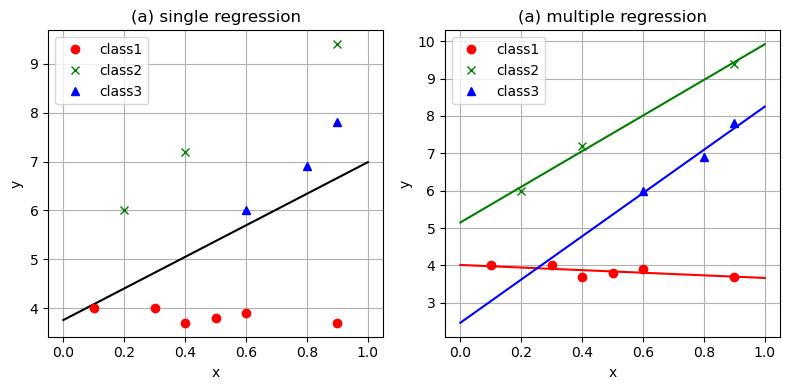

In [17]:
# 関数を可視化する範囲
xs = range(0, 1, length=100)

fig, axes = subplots(1, 2, figsize=(8, 4))

# 単一の回帰
axes[1].plot(xs, w₁ .* xs .+ w₂, "-k")

# 個別の回帰
axes[2].plot(xs, w₁s[1] .* xs .+ w₂s[1], "-r")
axes[2].plot(xs, w₁s[2] .* xs .+ w₂s[2], "-g")
axes[2].plot(xs, w₁s[3] .* xs .+ w₂s[3], "-b")

# データの回帰
for ax in axes
    ax.plot(X_obs[1], Y_obs[1], "or", label="class1")
    ax.plot(X_obs[2], Y_obs[2], "xg", label="class2")
    ax.plot(X_obs[3], Y_obs[3], "^b", label="class3")
end

set_options(axes[1], "x", "y", "(a) single regression", legend=true)
set_options(axes[2], "x", "y", "(a) multiple regression", legend=true)

tight_layout()

In [18]:
# 初期値
w_init = randn(8)

# サンプリング
maxiter = 1000
param_posterior_HMC, num_accepted_HMC =
    inference_wrapper_HMC(log_joint, paras, w_init, maxiter=maxiter, L=100, ϵ=0.01)

([-1.1118528389852462 0.7928599104383912 … 2.2285508820829443 3.343727416575211; 2.681440956359533 2.1774926839372806 … 3.016004037278015 3.8858584265900182; … ; 1.0239690264264159 8.117941338153132 … 3.6427024082635557 5.247246067048797; 0.7470848288724954 7.306465227885195 … 4.4085390489111775 4.674840600490744], 1000)

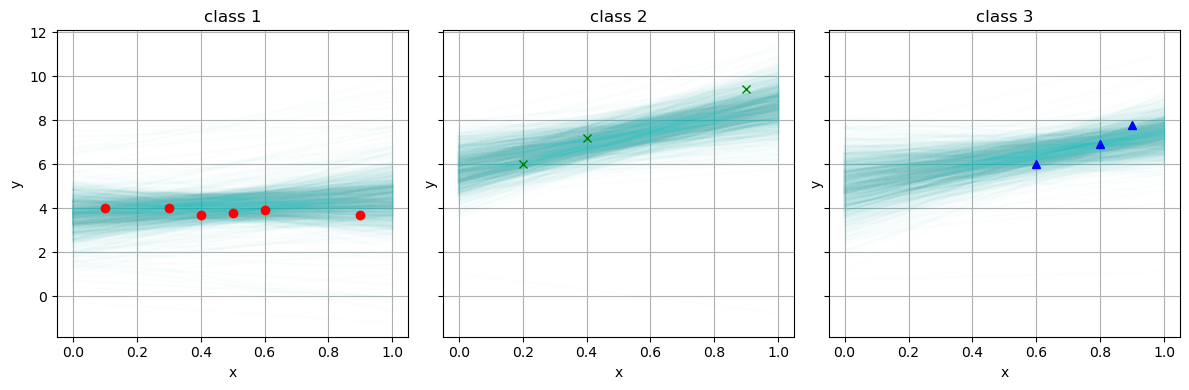

In [19]:
# 予測分布の可視化
fig, axes = subplots(1, 3, sharey=true, figsize=(12, 4))

for i in 1:3
    for j in 1:size(param_posterior_HMC, 2)
        w₁, w₂ = param_posterior_HMC[[2+i, 2+i+3], j]
        axes[i].plot(xs, w₁ .* xs .+ w₂, "c-", alpha=0.01)
    end
    set_options(axes[i], "x", "y", "class $(i)")
end
axes[1].plot(X_obs[1], Y_obs[1], "or")
axes[2].plot(X_obs[2], Y_obs[2], "xg")
axes[3].plot(X_obs[3], Y_obs[3], "^b")

tight_layout()